<a href="https://colab.research.google.com/github/rinayaha/screentime/blob/main/unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Research Question:
Can unsupervised clusters based on grape variety, price, and region predict expert score—or reveal undervalued segments?

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving winemag-data_first150k.csv to winemag-data_first150k (2).csv


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
!pip install hdbscan

# Load the data
df = pd.read_csv("winemag-data_first150k.csv")

# Select relevant columns
selected_cols = ["variety", "price", "province", "points"]
df = df[selected_cols]

# Drop rows with missing values
df = df.dropna(subset=selected_cols).copy()

# Drop rare categories to avoid high dimensionality
variety_counts = df['variety'].value_counts()
province_counts = df['province'].value_counts()

# Keep only common varieties/provinces (threshold: appears at least 100 times)
common_varieties = variety_counts[variety_counts >= 100].index
common_provinces = province_counts[province_counts >= 100].index

df = df[df['variety'].isin(common_varieties) & df['province'].isin(common_provinces)]

# Result: df is clean, filtered, and ready for encoding
print(f"Final shape: {df.shape}")
print(df.head())

Final shape: (125170, 4)
              variety  price        province  points
0  Cabernet Sauvignon  235.0      California      96
1       Tinta de Toro  110.0  Northern Spain      96
2     Sauvignon Blanc   90.0      California      96
3          Pinot Noir   65.0          Oregon      96
5       Tinta de Toro   73.0  Northern Spain      95


In [ ]:
# Sample data
SAMPLE_SIZE = 20000
RANDOM_SEED = 42

print(f"Original shape: {df.shape}")

if df.shape[0] > SAMPLE_SIZE:
    # Use .sample() to select a random, fixed number of rows
    df = df.sample(n=SAMPLE_SIZE, random_state=RANDOM_SEED).copy()
    print(f" Data sampled successfully to {SAMPLE_SIZE} records.")
else:
    print("No sampling performed, dataset is already small enough.")

print(f"New shape for subsequent analysis: {df.shape}")

Original shape: (20000, 4)
No sampling performed, dataset is already small enough.
New shape for subsequent analysis: (20000, 4)


In [ ]:
from sklearn.preprocessing import StandardScaler

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=["variety", "province"], drop_first=True)

# Normalize 'price'
scaler = StandardScaler()
df_encoded["price_scaled"] = scaler.fit_transform(df_encoded[["price"]])

# Drop original 'price' and 'points' from features
X = df_encoded.drop(columns=["price", "points"])

# Save the expert score separately for evaluation later
y = df_encoded["points"].copy()

# X is the feature matrix for clustering, y is the expert score for validation
print(f"Feature matrix shape: {X.shape}")
print(X.head())

Feature matrix shape: (20000, 165)
        variety_Albariño  variety_Barbera  variety_Blaufränkisch  \
93096              False            False                  False   
110760             False            False                  False   
136538             False            False                  False   
126188             False            False                  False   
23543              False            False                  False   

        variety_Bonarda  variety_Bordeaux-style Red Blend  \
93096             False                             False   
110760            False                             False   
136538            False                             False   
126188            False                             False   
23543             False                             False   

        variety_Bordeaux-style White Blend  variety_Cabernet Blend  \
93096                                False                   False   
110760                               False       

In [ ]:
# Reduce to 2 principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Reduce dimensionality
dims_to_try = [10, 50, 100]
X_reduced_dict = {}

for dim in dims_to_try:
    svd = TruncatedSVD(n_components=dim, random_state=0)
    X_reduced = svd.fit_transform(X)
    X_reduced_dict[dim] = X_reduced
    print(f"Reduced to {dim} dimensions. Shape: {X_reduced.shape}")

Reduced to 10 dimensions. Shape: (20000, 10)
Reduced to 50 dimensions. Shape: (20000, 50)
Reduced to 100 dimensions. Shape: (20000, 100)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

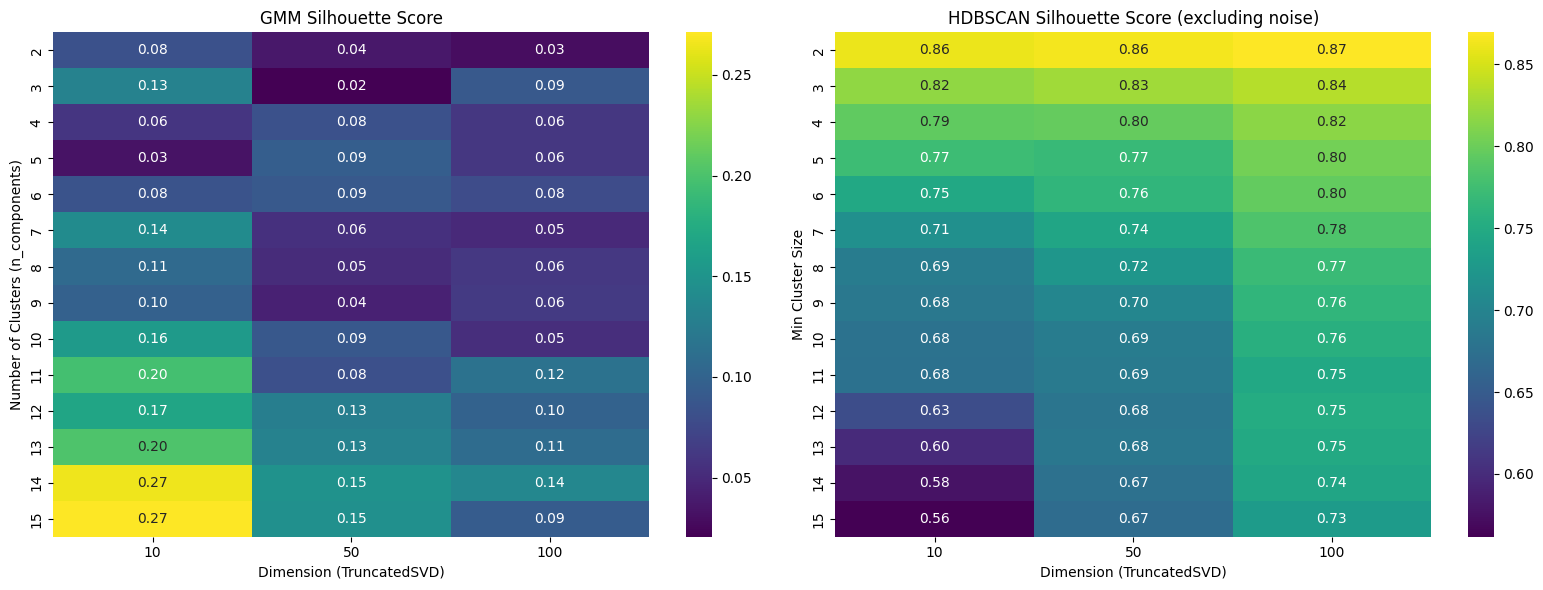

In [ ]:
# Required Imports
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
import hdbscan
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define grid ranges
dimension_range = [10, 50, 100]
cluster_range = list(range(2, 16))  # Number of clusters or min_cluster_size

# Initialize results
gmm_results = []
hdbscan_results = []

# Grid Search Loop
for dim in dimension_range:
    X_dim = X_reduced_dict[dim]

    for k in cluster_range:
        # GMM
        try:
            gmm = GaussianMixture(n_components=k, random_state=42)
            gmm_labels = gmm.fit_predict(X_dim)
            score = silhouette_score(X_dim, gmm_labels)
            gmm_results.append({'dim': dim, 'n_clusters': k, 'silhouette': score})
        except:
            gmm_results.append({'dim': dim, 'n_clusters': k, 'silhouette': np.nan})

        # HDBSCAN
        # HDBSCAN requires min_cluster_size >= 2
        if k >= 2:
            try:
                hdb = hdbscan.HDBSCAN(min_cluster_size=k)
                hdb_labels = hdb.fit_predict(X_dim)

                # Filter out noise (-1) for silhouette score
                if len(set(hdb_labels)) > 1:
                    mask = hdb_labels != -1
                    # Ensure enough points remain after removing noise
                    if len(np.unique(hdb_labels[mask])) > 1 and len(hdb_labels[mask]) > 1:
                        score = silhouette_score(X_dim[mask], hdb_labels[mask])
                        hdbscan_results.append({'dim': dim, 'min_cluster_size': k, 'silhouette': score})
                    else:
                        hdbscan_results.append({'dim': dim, 'min_cluster_size': k, 'silhouette': np.nan})
                else:
                    hdbscan_results.append({'dim': dim, 'min_cluster_size': k, 'silhouette': np.nan})
            except:
                hdbscan_results.append({'dim': dim, 'min_cluster_size': k, 'silhouette': np.nan})

# Convert to DataFrames
df_gmm = pd.DataFrame(gmm_results)
df_hdbscan = pd.DataFrame(hdbscan_results)

# Pivot for heatmap
gmm_heatmap = df_gmm.pivot(index='n_clusters', columns='dim', values='silhouette')
hdbscan_heatmap = df_hdbscan.pivot(index='min_cluster_size', columns='dim', values='silhouette')

# Plot heatmaps
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(gmm_heatmap, annot=True, cmap="viridis", fmt=".2f")
plt.title("GMM Silhouette Score")
plt.xlabel("Dimension (TruncatedSVD)")
plt.ylabel("Number of Clusters (n_components)")

plt.subplot(1, 2, 2)
sns.heatmap(hdbscan_heatmap, annot=True, cmap="viridis", fmt=".2f")
plt.title("HDBSCAN Silhouette Score (excluding noise)")
plt.xlabel("Dimension (TruncatedSVD)")
plt.ylabel("Min Cluster Size")

plt.tight_layout()
plt.show()

best_hdbscan_k = 50
best_hdbscan_dim = 50

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mutual_info_score
import numpy as np
import pandas as pd

# Store results
kmeans_results = []
# Use a wider range of K for better elbow analysis visualization later
kmeans_k_range = [2, 4, 6, 8, 10, 12, 14]

for dim, X_reduced in X_reduced_dict.items():
    print(f"\n Running K-Means on {dim} dimensions")

    for k in kmeans_k_range:
        try:
            kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto', max_iter=300)
            labels = kmeans.fit_predict(X_reduced)

            # Evaluation
            sil_score = silhouette_score(X_reduced, labels)

            y_temp_binned = pd.cut(y, bins=10, labels=False, include_lowest=True)
            mi_score = mutual_info_score(y_temp_binned, labels)

            # Store results
            kmeans_results.append({
                'dim': dim,
                'n_clusters': k,
                'silhouette': sil_score,
                'mutual_info': mi_score,
                'avg_score': (sil_score + mi_score) / 2
            })

            print(f"K={k:>2} | Silhouette: {sil_score:.3f} | MI: {mi_score:.3f} | Avg: {(sil_score + mi_score)/2:.3f}")
        except Exception as e:
            print(f"Error for K={k}: {e}")
            kmeans_results.append({
                'dim': dim,
                'n_clusters': k,
                'silhouette': np.nan,
                'mutual_info': np.nan,
                'avg_score': np.nan
            })

# Re-convert to DataFrame for potential analysis
df_kmeans = pd.DataFrame(kmeans_results)
print("\nK-Means Results Table:")
print(df_kmeans.pivot(index='n_clusters', columns='dim', values='avg_score'))


📊 Running K-Means on 10 dimensions
K= 2 | Silhouette: 0.682 | MI: 0.031 | Avg: 0.356
K= 4 | Silhouette: 0.295 | MI: 0.085 | Avg: 0.190
K= 6 | Silhouette: 0.324 | MI: 0.109 | Avg: 0.216
K= 8 | Silhouette: 0.324 | MI: 0.116 | Avg: 0.220
K=10 | Silhouette: 0.355 | MI: 0.109 | Avg: 0.232
K=12 | Silhouette: 0.398 | MI: 0.114 | Avg: 0.256
K=14 | Silhouette: 0.438 | MI: 0.116 | Avg: 0.277

📊 Running K-Means on 50 dimensions
K= 2 | Silhouette: 0.146 | MI: 0.035 | Avg: 0.091
K= 4 | Silhouette: 0.147 | MI: 0.089 | Avg: 0.118
K= 6 | Silhouette: 0.151 | MI: 0.111 | Avg: 0.131
K= 8 | Silhouette: 0.157 | MI: 0.124 | Avg: 0.141
K=10 | Silhouette: 0.172 | MI: 0.123 | Avg: 0.147
K=12 | Silhouette: 0.183 | MI: 0.129 | Avg: 0.156
K=14 | Silhouette: 0.212 | MI: 0.121 | Avg: 0.166

📊 Running K-Means on 100 dimensions
K= 2 | Silhouette: 0.575 | MI: 0.031 | Avg: 0.303
K= 4 | Silhouette: 0.125 | MI: 0.089 | Avg: 0.107
K= 6 | Silhouette: 0.048 | MI: 0.123 | Avg: 0.085
K= 8 | Silhouette: 0.146 | MI: 0.107 | Av

In [ ]:
# Fit KMeans on the 10-dimensional data
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

# Define the optimal configuration based on grid search
BEST_DIM = 10
BEST_K = 8

X_best = X_reduced_dict[BEST_DIM]
kmeans_final = KMeans(n_clusters=BEST_K, random_state=0, n_init='auto')
final_labels = kmeans_final.fit_predict(X_best)

# Add cluster labels to original dataframe
df_clustered = df.copy()
df_clustered['cluster'] = final_labels

# Save silhouette score to variable
kmeans_silhouette = silhouette_score(X_best, final_labels)
print("Silhouette Score for best config:", kmeans_silhouette)
print(f"Using Dimension={BEST_DIM}, K={BEST_K}\n")

# Profile: average stats by cluster
# Corrected lambda functions for mode calculation
cluster_profile = df_clustered.groupby('cluster').agg({
    'price': ['mean', 'median'],
    'points': ['mean', 'median'],
    'variety': lambda x: x.value_counts().index[0],
    'province': lambda x: x.value_counts().index[0],
    'cluster': 'count'
}).rename(columns={'cluster': 'count'})

# Clean up column names
cluster_profile.columns = ['_'.join(col).strip() for col in cluster_profile.columns.values]
cluster_profile = cluster_profile.sort_values(by='points_mean', ascending=False)


print("--- Cluster Profile (Sorted by Mean Points) ---")
pd.set_option('display.max_columns', None)
print(cluster_profile)

# Find the 'undervalued' segment: high points mean, low price median
undervalued_cluster = cluster_profile[cluster_profile['points_mean'] >= 92].sort_values(by='price_median', ascending=True).iloc[0]
print("\n--- Undervalued Segment Analysis ---")
print(f"The best candidate for an undervalued segment (high score, lowest price) is:")
print(undervalued_cluster)

Silhouette Score for best config: 0.323511671345407
Using Dimension=10, K=8

--- Cluster Profile (Sorted by Mean Points) ---
          price_mean  price_median  points_mean  points_median  \
cluster                                                          
4        1013.333333         990.0    95.500000           95.0   
5         424.846154         398.0    95.384615           95.0   
6         182.239203         172.0    92.913621           93.0   
1          75.740825          72.0    91.069778           91.0   
2        2013.000000        2013.0    91.000000           91.0   
7          39.291209          40.0    88.568432           88.0   
3          21.848005          19.0    87.387514           87.0   
0          27.098485          25.0    86.976276           87.0   

                 variety_<lambda> province_<lambda>  count_count  
cluster                                                           
4        Bordeaux-style Red Blend          Bordeaux            6  
5            

Running t-SNE (this may take a few minutes)...


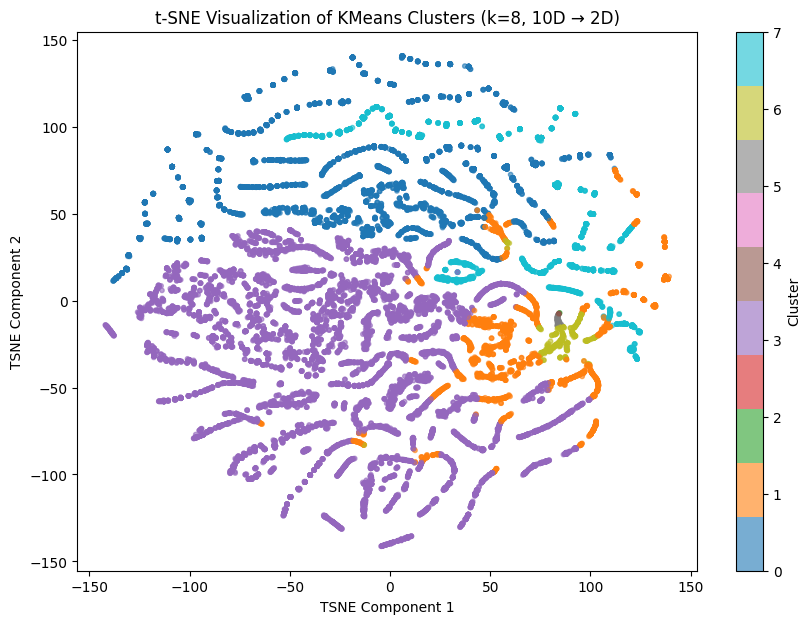

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

BEST_DIM_KMEANS = 10
BEST_K_KMEANS = 8

# Using the optimal 10D data
X_best = X_reduced_dict[BEST_DIM_KMEANS]
# Using the final labels from KMeans(k=8)
final_labels = df_clustered['cluster'].values

print("Running t-SNE")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_jobs=-1, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_best)

# Plot clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=final_labels, cmap='tab10', alpha=0.6, s=10)
# Use the defined variables for the title
plt.title(f"t-SNE Visualization of KMeans Clusters (k={BEST_K_KMEANS}, {BEST_DIM_KMEANS}D → 2D)")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.colorbar(scatter, label="Cluster")
plt.show()

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=315, random_state=42)
kmeans.fit(X_pca)


loss = kmeans.inertia_
print("K-Means Loss (Inertia):", loss)
kmeans_labels = kmeans.labels_

K-Means Loss (Inertia): 9.911591774142188


In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=15, random_state=42)
gmm.fit(X_pca)
gmm_labels = gmm.predict(X_pca)


gmm_silhouette = silhouette_score(X, gmm_labels)
print(f"GMM Silhouette Score: {gmm_silhouette:.3f}")

GMM Silhouette Score: 0.045


In [ ]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
hdb_labels = clusterer.fit_predict(X_pca)
mask = hdb_labels != -1
hdb_silhouette = silhouette_score(X[mask], hdb_labels[mask])
print(f"HDBSCAN Silhouette Score (excluding noise): {hdb_silhouette:.3f}")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN Silhouette Score (excluding noise): 0.067


In [ ]:
points_bins = pd.cut(df['points'], bins=[79, 84, 89, 94, 100], labels=[0, 1, 2, 3])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



--- Final Model Comparison ---
  Algorithm  Silhouette  Mutual Information  Weighted Score
0   K-Means    0.323512            0.093745        0.208628
1       GMM    0.082772            0.004614        0.043693
2   HDBSCAN    0.618875            0.109203        0.364039


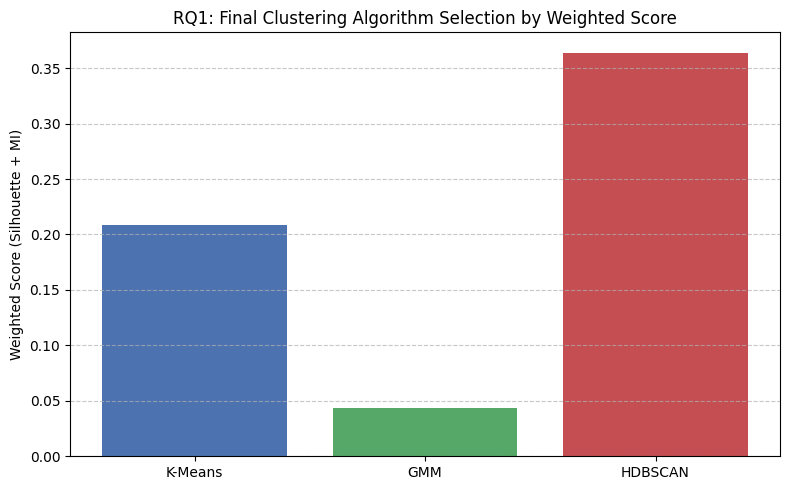

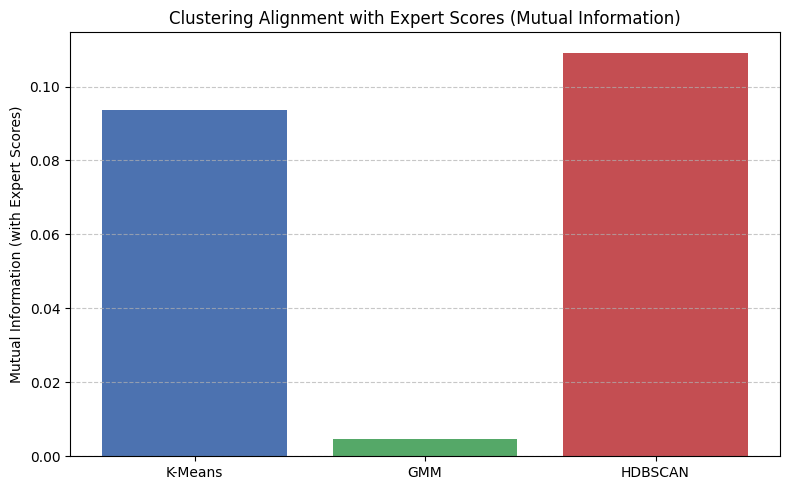

In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import hdbscan
from sklearn.metrics import silhouette_score, mutual_info_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define final models with optimal parameters
BEST_DIM_KMEANS = 10
BEST_K_KMEANS = 8

BEST_DIM_GMM = 10
BEST_K_GMM = 2

BEST_DIM_HDBSCAN = 50
BEST_K_HDBSCAN = 50

points_bins = pd.cut(df['points'], bins=[79, 84, 89, 94, 100], labels=[0, 1, 2, 3], right=True)

# Run final models and collect metrics

# K-Means
X_kmeans = X_reduced_dict[BEST_DIM_KMEANS]
kmeans_final = KMeans(n_clusters=BEST_K_KMEANS, random_state=0, n_init='auto')
kmeans_labels = kmeans_final.fit_predict(X_kmeans)
kmeans_silhouette = silhouette_score(X_kmeans, kmeans_labels)
mi_kmeans = mutual_info_score(points_bins, kmeans_labels)

# GMM
X_gmm = X_reduced_dict[BEST_DIM_GMM]
gmm_final = GaussianMixture(n_components=BEST_K_GMM, random_state=42)
gmm_labels = gmm_final.fit_predict(X_gmm)
gmm_silhouette = silhouette_score(X_gmm, gmm_labels)
mi_gmm = mutual_info_score(points_bins, gmm_labels)

# HDBSCAN
X_hdb = X_reduced_dict[BEST_DIM_HDBSCAN]
hdb_final = hdbscan.HDBSCAN(min_cluster_size=BEST_K_HDBSCAN)
hdb_labels = hdb_final.fit_predict(X_hdb)
mask = hdb_labels != -1
# Calculate silhouette only on non-noise points
if len(np.unique(hdb_labels[mask])) > 1:
    hdb_silhouette = silhouette_score(X_hdb[mask], hdb_labels[mask])
else:
    hdb_silhouette = np.nan
# Calculate MI only on non-noise points
mi_hdbscan = mutual_info_score(points_bins[mask], hdb_labels[mask])


# Create combined results table and Weighted Score
results_df = pd.DataFrame({
    "Algorithm": ["K-Means", "GMM", "HDBSCAN"],
    "Silhouette": [kmeans_silhouette, gmm_silhouette, hdb_silhouette],
    "Mutual Information": [mi_kmeans, mi_gmm, mi_hdbscan]
})

results_df['Weighted Score'] = (results_df['Silhouette'] + results_df['Mutual Information']) / 2
print("\n--- Final Model Comparison ---")
print(results_df)


# Plot Weighted Score for final comparison
plt.figure(figsize=(8, 5))
plt.bar(results_df['Algorithm'], results_df['Weighted Score'], color=['#4C72B0', '#55A868', '#C44E52'])
plt.ylabel('Weighted Score (Silhouette + MI)')
plt.title('RQ1: Final Clustering Algorithm Selection by Weighted Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot MI
plt.figure(figsize=(8, 5))
plt.bar(results_df['Algorithm'], results_df['Mutual Information'], color=['#4C72B0', '#55A868', '#C44E52'])
plt.ylabel('Mutual Information (with Expert Scores)')
plt.title('Clustering Alignment with Expert Scores (Mutual Information)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


--- Anomaly Detection Mutual Information (MI) ---
MI is generally low, suggesting no strong relationship with expert points.
      Algorithm  Mutual Information
2   OC-SVM (1%)            0.008405
0  K-Means (3σ)            0.006254
1      GMM (3σ)            0.004053


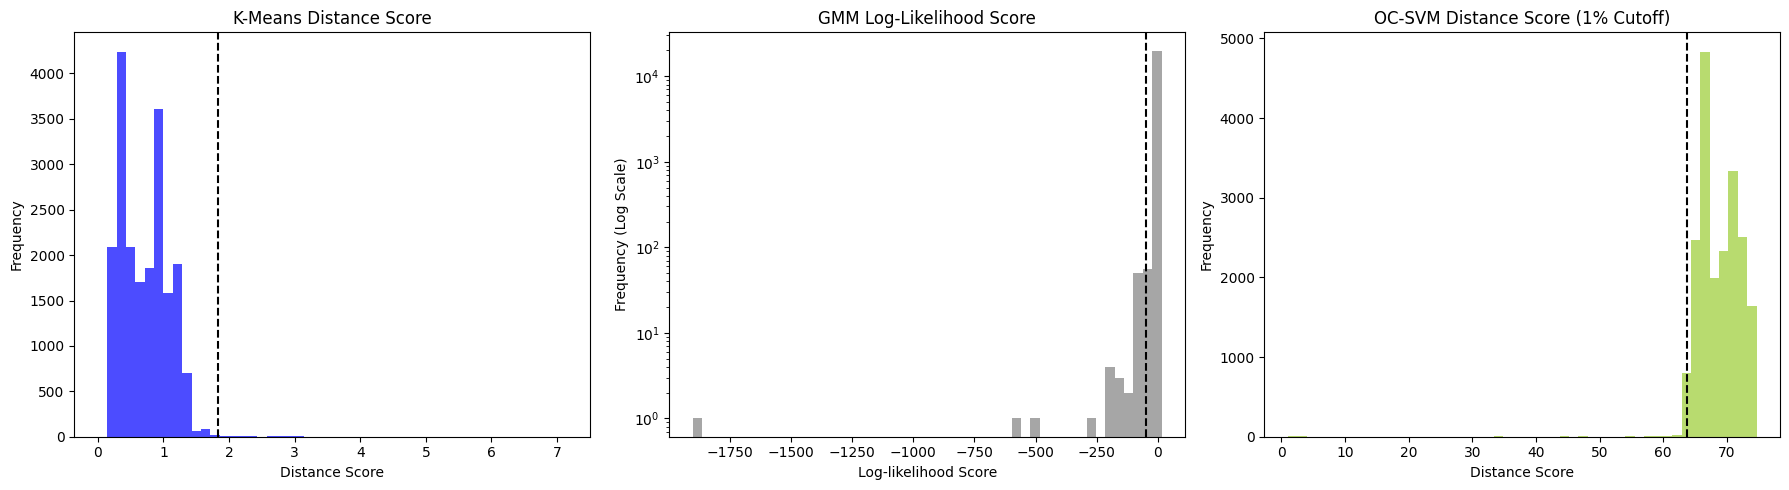

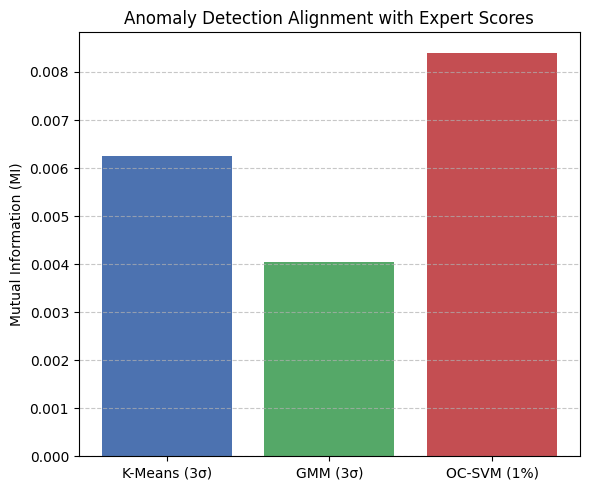

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import mutual_info_score
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Using the optimal 10D data from K-Means Clustering
X_anomaly = X_reduced_dict[10]

# K-MEANS ANOMALY DETECTION
kmeans_anomaly_scores = kmeans_final.transform(X_anomaly).min(axis=1)
cutoff_kmeans = np.mean(kmeans_anomaly_scores) + 3 * np.std(kmeans_anomaly_scores)
kmeans_anomaly_labels = (kmeans_anomaly_scores > cutoff_kmeans).astype(int)

# GMM ANOMALY DETECTION
gmm_anomaly_scores = gmm_final.score_samples(X_anomaly)
cutoff_gmm = np.mean(gmm_anomaly_scores) - 3 * np.std(gmm_anomaly_scores)
gmm_anomaly_labels = (gmm_anomaly_scores < cutoff_gmm).astype(int)

# ONE-CLASS SVM ANOMALY DETECTION
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)
ocsvm_scores = ocsvm.fit(X_anomaly).score_samples(X_anomaly)

percentile_99 = np.percentile(ocsvm_scores, 1)
ocsvm_anomaly_labels = (ocsvm_scores < percentile_99).astype(int)


# Evaluate Anomaly Alignment with Expert Scores (MI)
mi_kmeans_anom = mutual_info_score(points_bins, kmeans_anomaly_labels)
mi_gmm_anom = mutual_info_score(points_bins, gmm_anomaly_labels)
mi_ocsvm_anom = mutual_info_score(points_bins, ocsvm_anomaly_labels)

anomaly_mi_df = pd.DataFrame({
    "Algorithm": ["K-Means (3σ)", "GMM (3σ)", "OC-SVM (1%)"],
    "Mutual Information": [mi_kmeans_anom, mi_gmm_anom, mi_ocsvm_anom]
})

print("\n--- Anomaly Detection Mutual Information (MI) ---")
print("MI is generally low, suggesting no strong relationship with expert points.")
print(anomaly_mi_df.sort_values(by='Mutual Information', ascending=False))

# Plot Scores Histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# K-Means Histogram
axes[0].hist(kmeans_anomaly_scores, bins=50, color='blue', alpha=0.7)
axes[0].axvline(cutoff_kmeans, color='black', linestyle='--')
axes[0].set_title('K-Means Distance Score')
axes[0].set_xlabel('Distance Score')
axes[0].set_ylabel('Frequency')

# GMM Histogram
axes[1].hist(gmm_anomaly_scores, bins=50, color='gray', alpha=0.7)
axes[1].axvline(cutoff_gmm, color='black', linestyle='--')
axes[1].set_title('GMM Log-Likelihood Score')
axes[1].set_xlabel('Log-likelihood Score')
axes[1].set_ylabel('Frequency (Log Scale)')
axes[1].set_yscale('log')

# OC-SVM Histogram
axes[2].hist(ocsvm_scores, bins=50, color='yellowgreen', alpha=0.7)
axes[2].axvline(percentile_99, color='black', linestyle='--')
axes[2].set_title('OC-SVM Distance Score (1% Cutoff)')
axes[2].set_xlabel('Distance Score')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot MI Bar Chart
plt.figure(figsize=(6, 5))
plt.bar(anomaly_mi_df['Algorithm'], anomaly_mi_df['Mutual Information'], color=['#4C72B0', '#55A868', '#C44E52'])
plt.ylabel('Mutual Information (MI)')
plt.title('Anomaly Detection Alignment with Expert Scores')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()